# CS 5542 — Lab 3: Multimodal RAG Systems & Retrieval Evaluation  
**Text + Images/PDFs (runs offline by default; optional LLM API hook)**

This notebook is a **student-ready, simplified, and fully runnable** lab workflow for **multimodal retrieval-augmented generation (RAG)**:
- ingest **PDF text** + **image captions/filenames**
- retrieve evidence with a lightweight baseline (TF‑IDF)
- build a **context block** for answering
- evaluate retrieval quality (Precision@5, Recall@10)
- run an **ablation study** (REQUIRED)

> ✅ **Important:** The code is optimized for **clarity + reproducibility for students** (minimal dependencies, no keys required).  
> It is not the “fastest possible” or “best-performing” RAG system — but it is a correct baseline that you can extend.

---

## Student Tasks (what you must do)
1. **Ingest** PDFs + images from `project_data_mm/` (or use the provided sample package).  
2. Implement / experiment with **chunking strategies** (page-based vs fixed-size).  
3. Compare retrieval methods (at least):  
   - **Sparse** (TF‑IDF / BM25-style)  
   - **Dense** (optional: embeddings)  
   - **Hybrid** (score fusion with `alpha`)  
   - **Hybrid + rerank** (optional: reranker / LLM rerank)  
4. Build a **multimodal context** that includes **evidence items** (text + images).  
5. Produce the required **results table**:

`Query × Method × Precision@5 × Recall@10 × Faithfulness`

---

## Expected Outputs (what graders look for)
- Printed ingestion counts (how many PDF pages/chunks, how many images)
- A retrieval demo showing **top‑k evidence** for a query
- Evaluation metrics per method (P@5, R@10)
- An ablation section with a small comparison table + short explanation


## Key Parameters You Can Tune (and what they do)

These parameters control retrieval + context building. **Students should change them and report what happens.**

- **`TOP_K_TEXT`**: how many text chunks to consider as candidates.  
  - Larger → more recall, but more noise (lower precision).
- **`TOP_K_IMAGES`**: how many image items to consider as candidates.  
  - Larger → more multimodal evidence, but can add irrelevant images.
- **`TOP_K_EVIDENCE`**: how many total evidence items (text+image) go into the final context.  
  - Larger → longer context; may dilute answer quality.
- **`ALPHA`** *(0 → 1)*: **fusion weight** when mixing text vs image evidence.  
  - `ALPHA = 1.0` → text dominates  
  - `ALPHA = 0.0` → images dominate  
  - typical starting point: `0.5`
- **`CHUNK_SIZE`** (fixed-size chunking): characters per chunk (baseline).  
  - Smaller → more granular retrieval (often higher precision)  
  - Larger → fewer chunks (often higher recall but less specific)
- **`CHUNK_OVERLAP`**: overlap between chunks to avoid cutting important info.  
  - Too high → redundant chunks; too low → missing context boundaries

### What to try (recommended student experiments)
- Keep everything fixed, vary **`ALPHA`**: 0.2, 0.5, 0.8  
- Vary **`TOP_K_TEXT`**: 2, 5, 10  
- Compare **page-based** vs **fixed-size** chunking (required ablation)


## 0) Student Info (Fill in)
- Name: Ruixuan Hou
- UMKC ID: 16367969
- Course/Section: CS5542-0001


## 1) Setup (student-friendly baseline)

This lab starter is designed to be **easy to run** and **easy to modify**:
- **PyMuPDF (`fitz`)** for PDF text extraction
- **scikit-learn** for TF‑IDF retrieval (strong sparse baseline)
- **Pillow** for basic image IO
- Optional: connect an **LLM API** for answer generation (not required to run retrieval + eval)

### Student guideline
- First make sure **retrieval + metrics** run end-to-end.
- Then iterate: chunking → retrieval method → fusion (`ALPHA`) → rerank → faithfulness.

> If you have API keys (e.g., Gemini / OpenAI / etc.), you can plug them into the optional LLM hook later —  
> but your retrieval evaluation should work **without** any external keys.


In [1]:
# Imports
import os, re, glob, json, math
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple, Optional

import numpy as np
import pandas as pd

!pip install PyMuPDF
import fitz  # PyMuPDF
from PIL import Image, ImageDraw, ImageFont

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 71.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# =========================
# Lab Configuration (EDIT ME)
# =========================
# Students: try changing these and observe how retrieval metrics change.

DATA_DIR = "project_data_mm"   # folder containing pdfs/ and figures/ ; I changed to expected structure as below
PDF_DIR  = DATA_DIR
IMG_DIR  = os.path.join(DATA_DIR, "figures")

# Retrieval knobs
TOP_K_TEXT     = 5    # candidate text chunks
TOP_K_IMAGES   = 3    # candidate images (based on captions/filenames)
TOP_K_EVIDENCE = 8    # final evidence items used in the context

# Fusion knob (text vs images)
ALPHA = 0.5  # 0.0 = images dominate, 1.0 = text dominates

# Chunking knobs (for fixed-size chunking ablation)
CHUNK_SIZE    = 900   # characters per chunk
CHUNK_OVERLAP = 150   # overlap characters

# Reproducibility
RANDOM_SEED = 0


## 2) Data folder
Expected structure:
```
project_data_mm/
  doc1.pdf
  doc2.pdf
  figures/
    img1.png
    ... (>=5)
```
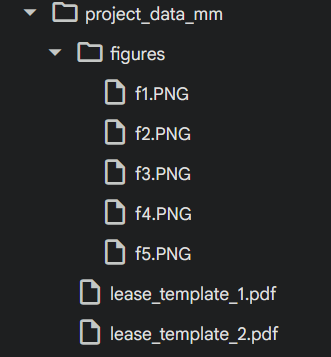

My folder structure is as above.

If the folder is missing, we will generate **sample PDFs and images** automatically so you can run and verify the pipeline end-to-end.


In [3]:
import shutil
shutil.rmtree("backup", ignore_errors=True)
print("empty")



empty


In [4]:
import glob
import os

DATA_DIR = "project_data_mm"
FIG_DIR = os.path.join(DATA_DIR, "figures")

pdfs = sorted(glob.glob(os.path.join(DATA_DIR, "*.pdf")))
imgs = sorted(glob.glob(os.path.join(FIG_DIR, "*.*")))

print("PDF:", pdfs)
print("IMG:", imgs)
print("PDFs now:", pdfs)
print("Images now:", imgs)

# I named my own folder project_data_mm too, so I will run this cell only

PDF: ['project_data_mm/lease_template_1.pdf', 'project_data_mm/lease_template_2.pdf']
IMG: ['project_data_mm/figures/f1.PNG', 'project_data_mm/figures/f2.PNG', 'project_data_mm/figures/f3.PNG', 'project_data_mm/figures/f4.PNG', 'project_data_mm/figures/f5.PNG']
PDFs now: ['project_data_mm/lease_template_1.pdf', 'project_data_mm/lease_template_2.pdf']
Images now: ['project_data_mm/figures/f1.PNG', 'project_data_mm/figures/f2.PNG', 'project_data_mm/figures/f3.PNG', 'project_data_mm/figures/f4.PNG', 'project_data_mm/figures/f5.PNG']


In [ ]:
!pip install reportlab

# Data paths
DATA_DIR = "project_data_mm"
FIG_DIR = os.path.join(DATA_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

def _write_sample_pdf(pdf_path: str, title: str, paragraphs: List[str]) -> None:
    """Create a simple multi-page PDF with ReportLab."""
    from reportlab.lib.pagesizes import letter
    from reportlab.pdfgen import canvas

    c = canvas.Canvas(pdf_path, pagesize=letter)
    width, height = letter
    y = height - 72

    c.setFont("Helvetica-Bold", 16)
    c.drawString(72, y, title)
    y -= 36
    c.setFont("Helvetica", 11)

    for p in paragraphs:
        # naive line wrapping
        words = p.split()
        line = ""
        for w in words:
            if len(line) + len(w) + 1 > 95:
                c.drawString(72, y, line)
                y -= 14
                line = w
                if y < 72:
                    c.showPage()
                    y = height - 72
                    c.setFont("Helvetica", 11)
            else:
                line = (line + " " + w).strip()
        if line:
            c.drawString(72, y, line)
            y -= 18

        if y < 72:
            c.showPage()
            y = height - 72
            c.setFont("Helvetica", 11)

    c.save()

def _write_sample_image(img_path: str, label: str, size=(900, 550)) -> None:
    """Create a simple image with a big label. Useful for verifying image ingestion."""
    img = Image.new("RGB", size, (245, 245, 245))
    d = ImageDraw.Draw(img)

    # Try a default font; if not available, PIL will fall back.
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 48)
    except Exception:
        font = ImageFont.load_default()

    d.rectangle([30, 30, size[0]-30, size[1]-30], outline=(30, 30, 30), width=6)
    d.text((60, 200), label, fill=(20, 20, 20), font=font)
    img.save(img_path)

def ensure_sample_dataset(min_pdfs=2, min_imgs=5) -> None:
    """Create a small dataset if user doesn't have one yet."""
    pdfs = sorted(glob.glob(os.path.join(DATA_DIR, "*.pdf")))
    imgs = sorted(glob.glob(os.path.join(FIG_DIR, "*.*")))

    if len(pdfs) >= min_pdfs and len(imgs) >= min_imgs:
        print("✅ Found existing dataset:", len(pdfs), "PDFs and", len(imgs), "images.")
        return

    print("⚠️ Dataset incomplete. Creating sample dataset...")

    # PDFs
    pdf1 = os.path.join(DATA_DIR, "sample_doc_rag_basics.pdf")
    pdf2 = os.path.join(DATA_DIR, "sample_doc_multimodal_eval.pdf")

    p1 = [
        "Retrieval-Augmented Generation (RAG) combines a retriever and a generator. The retriever fetches evidence chunks from documents.",
        "A common baseline is TF-IDF retrieval. Another baseline is BM25, which uses term frequency and inverse document frequency.",
        "Good RAG answers should be grounded in the retrieved evidence and should not hallucinate facts that are not supported.",
        "When evidence is missing, the system should say 'I don't know' or request more context.",
    ]
    p2 = [
        "Multimodal RAG includes both text (PDF pages) and images (figures). A simple approach is to attach relevant figures as evidence.",
        "Evaluation can include retrieval metrics such as Precision@k and Recall@k, plus qualitative checks for faithfulness.",
        "Ablation studies vary the chunking strategy, retriever type, or the number of retrieved items.",
        "Rubrics help define what counts as relevant evidence for each query.",
    ]

    _write_sample_pdf(pdf1, "Sample Doc 1: RAG Basics", p1)
    _write_sample_pdf(pdf2, "Sample Doc 2: Multimodal RAG + Evaluation", p2)

    # Images (named so text-based retrieval can match them)
    labels = [
        "figure_rag_pipeline",
        "figure_tfidf_retrieval",
        "figure_bm25_baseline",
        "figure_precision_recall",
        "figure_ablation_study",
    ]
    for lab in labels:
        _write_sample_image(os.path.join(FIG_DIR, f"{lab}.png"), lab)

    print("✅ Sample dataset created.")

ensure_sample_dataset()

pdfs = sorted(glob.glob(os.path.join(DATA_DIR, "*.pdf")))
imgs = sorted(glob.glob(os.path.join(FIG_DIR, "*.*")))

print("PDFs:", len(pdfs), pdfs)
print("Images:", len(imgs), imgs)


## 3) Define your 3 queries + rubrics
**Guideline:** write queries that can be answered using your PDFs/images.

Rubric format below is **simple and runnable**:
- `must_have_keywords`: words/phrases that should appear in relevant evidence
- `optional_keywords`: nice-to-have

Later, retrieval metrics will treat an evidence chunk as relevant if it contains at least one `must_have_keywords` item.


In [5]:
QUERIES = [
    {
        "id": "Q1",
        "question": "What are the rent amount and late fee policy in this lease agreement?",
        "rubric": {
            "must_have_keywords": ["rent", "late fee", "per month", "$", "grace period"],
            "optional_keywords": ["payment", "due", "monthly"]
        }
    },
    {
        "id": "Q2",
        "question": "What rules apply to pets and are there any additional fees?",
        "rubric": {
            "must_have_keywords": ["pets", "pet", "permission", "fee", "pet-rent"],
            "optional_keywords": ["cleaning", "deposit", "animals"]
        }
    },
    {
        "id": "Q3",
        "question": "Does the contract mention interest paid on the security deposit?",
        "rubric": {
            "must_have_keywords": ["security deposit", "interest"],
            "optional_keywords": ["refund", "deposit"]
        }
    },
]


## 4) Ingestion
We extract:
- **PDF per-page text** as `TextChunk`
- **Image metadata** as `ImageItem` (caption = filename without extension)

> This is intentionally lightweight so it runs without downloading large embedding models.


In [6]:
@dataclass
class TextChunk:
    chunk_id: str
    doc_id: str
    page_num: int
    text: str

@dataclass
class ImageItem:
    item_id: str
    path: str
    caption: str  # simple text to make image retrieval runnable

def clean_text(s: str) -> str:
    s = s or ""
    s = re.sub(r"\s+", " ", s).strip()
    return s

def extract_pdf_pages(pdf_path: str) -> List[TextChunk]:
    doc_id = os.path.basename(pdf_path)
    doc = fitz.open(pdf_path)
    out: List[TextChunk] = []
    for i in range(len(doc)):
        page = doc.load_page(i)
        text = clean_text(page.get_text("text"))
        if text:
            out.append(TextChunk(
                chunk_id=f"{doc_id}::p{i+1}",
                doc_id=doc_id,
                page_num=i+1,
                text=text
            ))
    return out

def load_images(fig_dir: str) -> List[ImageItem]:
    items: List[ImageItem] = []
    for p in sorted(glob.glob(os.path.join(fig_dir, "*.*"))):
        base = os.path.basename(p)
        caption = os.path.splitext(base)[0].replace("_", " ")
        items.append(ImageItem(item_id=base, path=p, caption=caption))
    return items

# Run ingestion
page_chunks: List[TextChunk] = []
for p in pdfs:
    page_chunks.extend(extract_pdf_pages(p))

image_items = load_images(FIG_DIR)

print("Total text chunks:", len(page_chunks))
print("Total images:", len(image_items))
print("Sample text chunk:", page_chunks[0].chunk_id, page_chunks[0].text[:180])
print("Sample image item:", image_items[0])


Total text chunks: 18
Total images: 5
Sample text chunk: lease_template_1.pdf::p1 STANDARD RESIDENTIAL LEASE AGREEMENT 1. THE PARTIES. This Residential Lease Agreement (“Agreement”) is made on the undersigned date by and between: Landlord Landlord's Name: [LANDL
Sample image item: ImageItem(item_id='f1.PNG', path='project_data_mm/figures/f1.PNG', caption='f1')


## 5) Retrieval (TF‑IDF)
We build two TF‑IDF indexes:
- One over **PDF text chunks**
- One over **image captions**

Retrieval returns the top‑k results with similarity scores.


In [7]:
def build_tfidf_index_text(chunks: List[TextChunk]):
    corpus = [c.text for c in chunks]
    vec = TfidfVectorizer(lowercase=True, stop_words="english")
    X = vec.fit_transform(corpus)
    X = normalize(X)
    return vec, X

def build_tfidf_index_images(items: List[ImageItem]):
    corpus = [it.caption for it in items]
    vec = TfidfVectorizer(lowercase=True, stop_words="english")
    X = vec.fit_transform(corpus)
    X = normalize(X)
    return vec, X

text_vec, text_X = build_tfidf_index_text(page_chunks)
img_vec, img_X = build_tfidf_index_images(image_items)

def tfidf_retrieve(query: str, vec: TfidfVectorizer, X, top_k: int = 5):
    q = vec.transform([query])
    q = normalize(q)
    scores = (X @ q.T).toarray().ravel()
    idx = np.argsort(-scores)[:top_k]
    return [(int(i), float(scores[i])) for i in idx]

print("✅ Indexes built.")


✅ Indexes built.


## 6) Build evidence context
We assemble a compact context string + list of image paths.

**Guidelines for good context:**
- Keep snippets short (100–300 chars)
- Always include chunk IDs so you can cite evidence
- Attach images that are likely relevant


In [8]:
def _normalize_scores(pairs):
    """Min-max normalize a list of (idx, score) to [0,1].
    If all scores equal, returns 1.0 for each item (so ordering stays stable).
    """
    if not pairs:
        return []
    scores = [s for _, s in pairs]
    lo, hi = min(scores), max(scores)
    if abs(hi - lo) < 1e-12:
        return [(i, 1.0) for i, _ in pairs]
    return [(i, (s - lo) / (hi - lo)) for i, s in pairs]


def build_context(
    question: str,
    top_k_text: int = TOP_K_TEXT,
    top_k_images: int = TOP_K_IMAGES,
    top_k_evidence: int = TOP_K_EVIDENCE,
    alpha: float = ALPHA,
) -> Dict[str, Any]:
    """Build a multimodal context block for the question.

    Students:
    - `top_k_text` / `top_k_images` control *candidate retrieval* per modality.
    - `top_k_evidence` controls the *final context size*.
    - `alpha` controls fusion: higher = prefer text evidence, lower = prefer images.

    This function returns:
    - `context`: a text block with the selected evidence (what you pass to an LLM)
    - `image_paths`: paths of images selected as evidence
    - `evidence`: structured evidence list (recommended for your report)
    """
    # 1) Retrieve candidates from each modality
    text_hits = tfidf_retrieve(question, text_vec, text_X, top_k=top_k_text)   # [(idx, score), ...]
    img_hits  = tfidf_retrieve(question, img_vec,  img_X,  top_k=top_k_images)

    # 2) Normalize scores per modality and fuse with ALPHA
    text_norm = _normalize_scores(text_hits)
    img_norm  = _normalize_scores(img_hits)

    fused = []
    for idx, s in text_norm:
        ch = page_chunks[idx]
        fused.append({
            "modality": "text",
            "id": ch.chunk_id,
            "raw_score": float(dict(text_hits).get(idx, 0.0)),
            "fused_score": float(alpha * s),
            "text": ch.text,
            "path": None,
        })

    for idx, s in img_norm:
        it = image_items[idx]
        fused.append({
            "modality": "image",
            "id": it.item_id,
            "raw_score": float(dict(img_hits).get(idx, 0.0)),
            "fused_score": float((1.0 - alpha) * s),
            "text": it.caption,     # we retrieve on caption/filename text
            "path": it.path,
        })

    # 3) Pick top fused evidence
    fused = sorted(fused, key=lambda d: d["fused_score"], reverse=True)[:top_k_evidence]

    # 4) Build the context string (what you feed into a generator/LLM)
    ctx_lines = []
    image_paths = []
    for ev in fused:
        if ev["modality"] == "text":
            snippet = (ev["text"] or "")[:260].replace("\n", " ")
            ctx_lines.append(f"[TEXT | {ev['id']} | fused={ev['fused_score']:.3f}] {snippet}")
        else:
            ctx_lines.append(f"[IMAGE | {ev['id']} | fused={ev['fused_score']:.3f}] caption={ev['text']}")
            image_paths.append(ev["path"])

    return {
        "question": question,
        "context": "\n".join(ctx_lines),
        "image_paths": image_paths,
        "text_hits": text_hits,
        "img_hits": img_hits,
        "evidence": fused,
        "alpha": alpha,
        "top_k_text": top_k_text,
        "top_k_images": top_k_images,
        "top_k_evidence": top_k_evidence,
    }


# --- Demo: what retrieval returns for one query ---
ctx_demo = build_context(QUERIES[0]["question"])
print(ctx_demo["context"])
print("Images:", ctx_demo["image_paths"])
print("Fusion alpha:", ctx_demo["alpha"])


[TEXT | lease_template_1.pdf::p2 | fused=0.500] 5. SECURITY DEPOSIT. (check one) ☐ - No Security Deposit. ☐ - Security Deposit. • Amount: $[AMOUNT] • Returning to Tenant: [#] days after lease termination. 6. LATE FEE. (check one) ☐ - No Late Fee. ☐ - Late Fee: (check one) ☐ - Fixed Amount. $[AMOUNT] for eac
[IMAGE | f1.PNG | fused=0.500] caption=f1
[IMAGE | f2.PNG | fused=0.500] caption=f2
[IMAGE | f3.PNG | fused=0.500] caption=f3
[TEXT | lease_template_2.pdf::p1 | fused=0.127] Teacher Resources for Consumer.gov | Developed for the FTC by the Center for Applied Linguistics SAMPLE RENTAL AGREEMENT (Basic / Beginning) THIS AGREEMENT made this 15th Day of June, 2012, by and between ABC Properties, herein called “Landlord,” and Silvia Ma
[TEXT | lease_template_1.pdf::p9 | fused=0.032] n.) Pets. If any property repairs, odor removal, or other maintenance is required due to the Tenant’s Pets, the costs shall be deducted from the Pet Fee or Security Deposit with an itemized list disclosed to 

## 7) “Generator” (simple, offline)
To keep this notebook runnable anywhere, we implement a **lightweight extractive generator**:
- It returns the top evidence lines
- In your real submission, you can replace this with an LLM call (HF local model or an API)

**Key rule:** the answer must stay consistent with evidence.


In [9]:
def simple_extractive_answer(question: str, context: str) -> str:
    lines = context.splitlines()
    if not lines:
        return "I don't know (no evidence retrieved)."
    # Return top 2 evidence lines as a "grounded" answer
    return (
        f"Question: {question}\n\n"
        "Grounded answer (extractive):\n"
        + "\n".join(lines[:2])
    )

def run_query(qobj, top_k_text=TOP_K_TEXT, top_k_images=TOP_K_IMAGES, top_k_evidence=TOP_K_EVIDENCE, alpha=ALPHA) -> Dict[str, Any]:
    question = qobj["question"]
    ctx = build_context(question, top_k_text=top_k_text, top_k_images=top_k_images, top_k_evidence=top_k_evidence, alpha=alpha)
    answer = simple_extractive_answer(question, ctx["context"])
    return {
        "id": qobj["id"],
        "question": question,
        "answer": answer,
        "context": ctx["context"],
        "image_paths": ctx["image_paths"],
        "text_hits": ctx["text_hits"],
        "img_hits": ctx["img_hits"],
    }

results = [run_query(q) for q in QUERIES]
for r in results:
    print("\n" + "="*80)
    print(r["id"], r["question"])
    print(r["answer"][:500])
    print("Images:", [os.path.basename(p) for p in r["image_paths"]])



Q1 What are the rent amount and late fee policy in this lease agreement?
Question: What are the rent amount and late fee policy in this lease agreement?

Grounded answer (extractive):
[TEXT | lease_template_1.pdf::p2 | fused=0.500] 5. SECURITY DEPOSIT. (check one) ☐ - No Security Deposit. ☐ - Security Deposit. • Amount: $[AMOUNT] • Returning to Tenant: [#] days after lease termination. 6. LATE FEE. (check one) ☐ - No Late Fee. ☐ - Late Fee: (check one) ☐ - Fixed Amount. $[AMOUNT] for eac
[IMAGE | f1.PNG | fused=0.500] caption=f1
Images: ['f1.PNG', 'f2.PNG', 'f3.PNG']

Q2 What rules apply to pets and are there any additional fees?
Question: What rules apply to pets and are there any additional fees?

Grounded answer (extractive):
[TEXT | lease_template_1.pdf::p4 | fused=0.500] ☐ - No Pets Allowed. ☐ - Pets are Allowed. Number of Pets: [#] Types: [PET TYPES] Maximum Weight (per pet): [#] Pounds Deposit (for all pets): $[AMOUNT] ☐ refundable ☐ non-refundable 12. SMOKING POLICY. (check on

## 8) Retrieval Evaluation (Precision@k / Recall@k)
We treat a text chunk as **relevant** for a query if it contains at least one `must_have_keywords` term.



In [10]:
def is_relevant_text(chunk_text: str, rubric: Dict[str, Any]) -> bool:
    text = chunk_text.lower()
    must = [k.lower() for k in rubric.get("must_have_keywords", [])]
    return any(k in text for k in must)

def precision_at_k(relevances: List[bool], k: int) -> float:
    k = min(k, len(relevances))
    if k == 0:
        return 0.0
    return sum(relevances[:k]) / k

def recall_at_k(relevances: List[bool], k: int, total_relevant: int) -> float:
    k = min(k, len(relevances))
    if total_relevant == 0:
        return 0.0
    return sum(relevances[:k]) / total_relevant

def eval_retrieval_for_query(qobj, top_k=10) -> Dict[str, Any]:
    question = qobj["question"]
    rubric = qobj["rubric"]

    hits = tfidf_retrieve(question, text_vec, text_X, top_k=top_k)
    rels = []
    for i, score in hits:
        rels.append(is_relevant_text(page_chunks[i].text, rubric))

    # Estimate total relevant in the corpus (for recall)
    total_rel = sum(is_relevant_text(ch.text, rubric) for ch in page_chunks)

    return {
        "id": qobj["id"],
        "P@5": precision_at_k(rels, 5),
        "R@10": recall_at_k(rels, 10, total_rel),
        "total_relevant_chunks": total_rel,
    }

eval_rows = [eval_retrieval_for_query(q) for q in QUERIES]
df_eval = pd.DataFrame(eval_rows)
df_eval


,id,P@5,R@10,total_relevant_chunks
0,Q1,1.0,0.600000,15
1,Q2,0.8,0.545455,11
2,Q3,0.8,1.000000,8


## 9) Ablation Study (REQUIRED)

You must compare **at least**:
- **Chunking A (page-based)** vs **Chunking B (fixed-size)**  
- **Sparse** vs **Dense** vs **Hybrid** vs **Hybrid + Rerank** *(dense/rerank can be optional extensions — but include at least sparse + one fusion variant)*  
- **Text-only RAG** vs **Multimodal RAG** (your context must include evidence items)

**Deliverable:** include a final results table in your README:

`Query × Method × Precision@5 × Recall@10 × Faithfulness`

### Quick ablation ideas
- Vary `TOP_K_TEXT`: 2, 5, 10  
- Vary `ALPHA`: 0.2, 0.5, 0.8  
- Compare page-chunking vs fixed-size (`CHUNK_SIZE` / `CHUNK_OVERLAP`)  


In [11]:
def ablation_topk_text(qobj, k_list=(2, 5, 10)):
    rows = []
    for k in k_list:
        rows.append({
            "id": qobj["id"],
            "top_k_text": k,
            **eval_retrieval_for_query(qobj, top_k=max(10, k))  # eval uses top_k hits
        })
    return rows

abl_rows = []
for q in QUERIES:
    abl_rows.extend(ablation_topk_text(q, k_list=(2, 5, 10)))

df_ablation = pd.DataFrame(abl_rows)[["id","top_k_text","P@5","R@10","total_relevant_chunks"]]
df_ablation


,id,top_k_text,P@5,R@10,total_relevant_chunks
0,Q1,2,1.0,0.600000,15
1,Q1,5,1.0,0.600000,15
2,Q1,10,1.0,0.600000,15
3,Q2,2,0.8,0.545455,11
4,Q2,5,0.8,0.545455,11
5,Q2,10,0.8,0.545455,11
6,Q3,2,0.8,1.000000,8
7,Q3,5,0.8,1.000000,8
8,Q3,10,0.8,1.000000,8


## 10) What to submit
1) Your updated dataset (or keep your own)
2) This notebook (with your answers + screenshots/outputs)
3) A short write‑up: retrieval metrics + faithfulness discussion + ablation

**Tip:** If you switch to an LLM, keep the same `build_context()` so the evidence is always visible.
